#Imports

In [1]:
#Import das libs
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Display dos parâmetros
from IPython.display import display
from ipywidgets import interact, IntSlider

# Separação dos dados
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit 

# Modelagem
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV  

In [2]:
# Carga dos dados 
df_hist = pd.read_csv('./Dados/Histórico_Demanda_Elétrica_Peru_2006-2021.csv', parse_dates=['date'], index_col=['date'])
df_tempo = pd.read_csv('./Dados/Tempo_Lima_2006-2021.csv',delimiter=',')
print(df_hist.shape)
print(df_tempo.shape)

(537696, 1)
(116934, 7)


#1 - Análise Exploratória


Para realizar essa etapa deve-se ter em mente as duas perguntas:
<ol>
<li> Como se comporta a demanda elétrica ao longo dos anos, meses, semanas, dias...?</li>
<li> Como se dá a ocorrência do pico intra diário?</li>

Vamos analisar cada um dos datasets separadamente, inicialmente.

## 1.1 - Histórico

**Histórico da demanda**: série temporal com o histórico da demanda de potência
elétrica da rede peruana com intervalo de amostragem de 15 minutos. A seguir
um descritivo breve das colunas presentes na base de dados.
<ul>
  <li>a. Nome do arquivo: Histórico Potência.csv</li>
  <li>b. Colunas:</li>
    <ul>
      <li>i. FECHA: momento da amostragem da demanda energética</li>
      <li>ii. EJECUTADO: valor da demanda de potência da rede elétrica peruana em MW </li>
    </ul>
</ul>

In [3]:
print(df_hist.shape)
df_hist.head()

(537696, 1)


,executado
date,
2006-01-01 00:00:00,2069.01876
2006-01-01 00:15:00,2733.44840
2006-01-01 00:30:00,2681.27092
2006-01-01 00:45:00,2633.54249
2006-01-01 01:00:00,2611.28745


In [4]:
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 537696 entries, 2006-01-01 00:00:00 to 2021-05-02 23:45:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   executado  537696 non-null  float64
dtypes: float64(1)
memory usage: 8.2 MB


In [5]:
df_hist.describe(include='all')

,executado
count,537696.000000
mean,4541.276321
std,1179.604167
min,1624.031180
25%,3553.986485
50%,4532.148740
75%,5494.771133
max,7316.133020


In [6]:
df_hist.isnull().any()

executado    False
dtype: bool

In [7]:
print(min(df_hist.index))
print(max(df_hist.index))

2006-01-01 00:00:00
2021-05-02 23:45:00


### 1.1.1 Analisando períodos

Aqui será realizado uma análise gráfica que responde à pergunta 1, que diz respeito à como se comporta a demanda energética ao longo do tempo.

Vamos analisar como a demanda é mostrada para todo o período analisado.

Text(0, 0.5, 'Potência da rede elétrica (MW)')

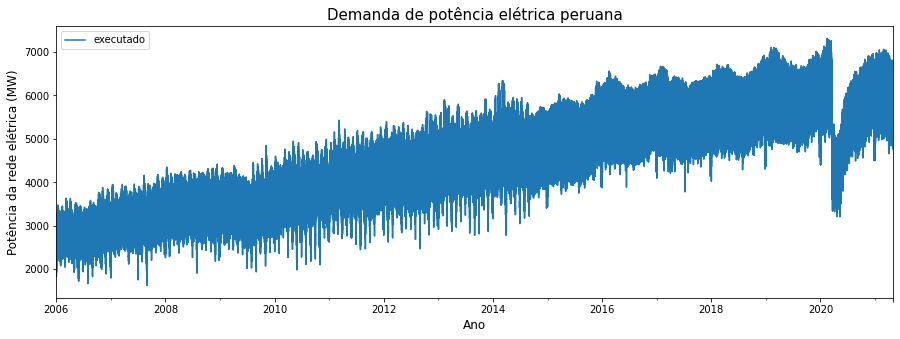

In [8]:
df_hist.plot(figsize=(15, 5))
plt.title('Demanda de potência elétrica peruana', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Potência da rede elétrica (MW)', fontsize=12)

Podemos enxergar uma tendência geral de aumento da demanda ao longo dos anos com uma alteração a partir de 2020, para podemos ver detalhes a respeito da série temporal é necessário observar a variação em pequenos períodos.

Aqui vamos pegar apenas o ano de 2006 e analisar mais detalhadamente.

Text(0, 0.5, 'Potência da rede elétrica (MW)')

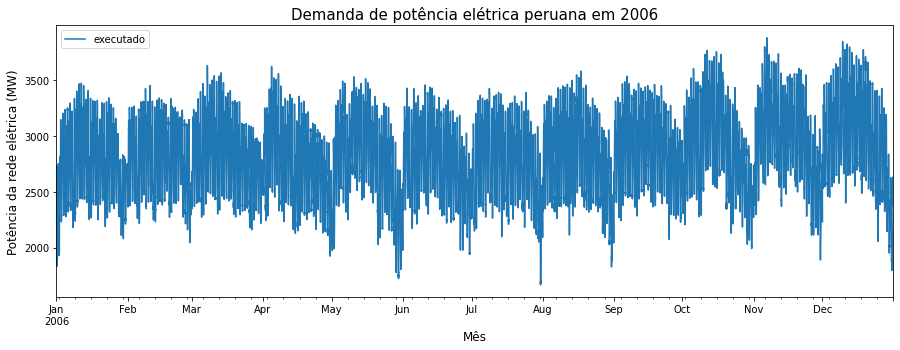

In [9]:
df_hist['2006'].plot(figsize=(15, 5))
plt.title('Demanda de potência elétrica peruana em 2006', fontsize=15)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Potência da rede elétrica (MW)', fontsize=12)

Percebe-se que existe uma certa sazonalidade ao longo de cada mês, vamos pegar junho de 2006.

Text(0, 0.5, 'Potência da rede elétrica (MW)')

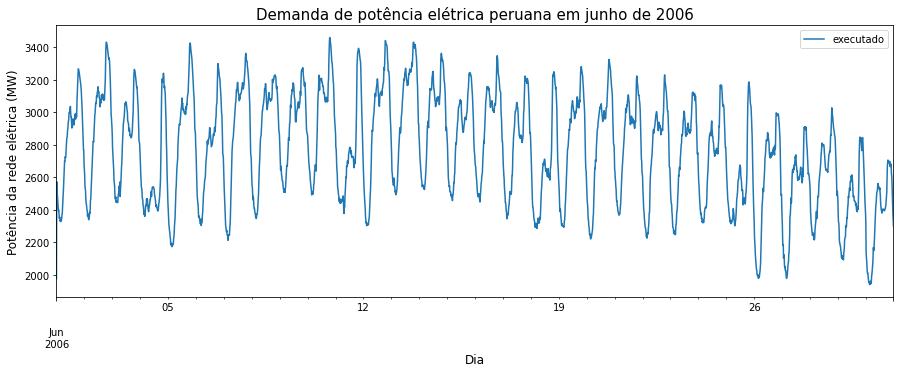

In [10]:
df_hist['2006-06'].plot(figsize=(15, 5))
plt.title('Demanda de potência elétrica peruana em junho de 2006', fontsize=15)
plt.xlabel('Dia', fontsize=12)
plt.ylabel('Potência da rede elétrica (MW)', fontsize=12)

Pode-se enxergar um certo padrão, que deverá ser analisado melhor. Vamos observar agora como é essa variação em cada dia, lembrando que a medição ocorre à cada 15 minutos.

Text(0, 0.5, 'Potência da rede elétrica (MW)')

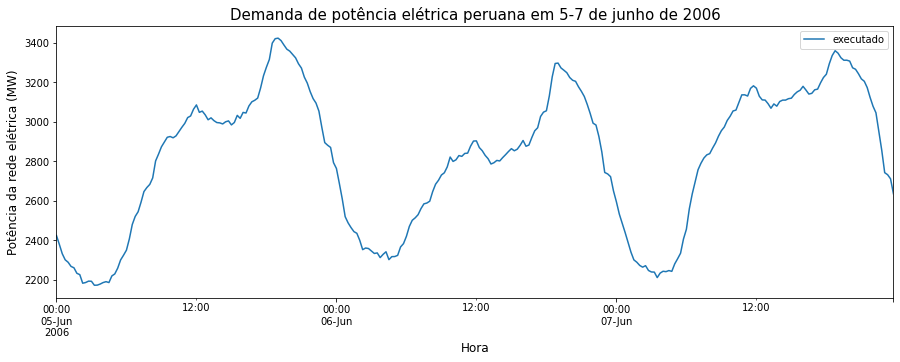

In [11]:
df_hist['2006-06-05':'2006-06-07'].plot(figsize=(15, 5))
plt.title('Demanda de potência elétrica peruana em 5-7 de junho de 2006', fontsize=15)
plt.xlabel('Hora', fontsize=12)
plt.ylabel('Potência da rede elétrica (MW)', fontsize=12)

Percebe-se uma certa ciclicidade que deverá ser melhor abordada, mas podemos responder à segunda pergunta aqui, pois vemos que existe um pico no final do período de meio dia à meia noite. Vamos ver melhor:

Text(0, 0.5, 'Potência da rede elétrica (MW)')

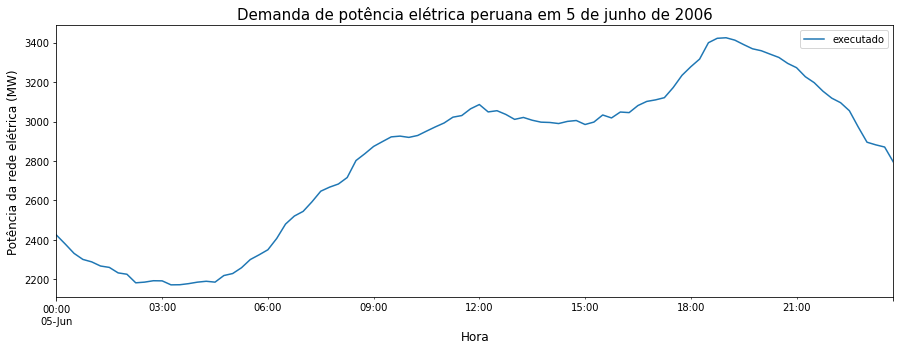

In [12]:
df_hist['2006-06-05'].plot(figsize=(15, 5))
plt.title('Demanda de potência elétrica peruana em 5 de junho de 2006', fontsize=15)
plt.xlabel('Hora', fontsize=12)
plt.ylabel('Potência da rede elétrica (MW)', fontsize=12)

O pico ocorre por volta das 19hs, segundo uma aproximação do gráfico.

### 1.1.2 Mediana

Podemos ver que existe algum padrão temporal, vamos ver como a mediana funciona ao longo de cada período de tempo.

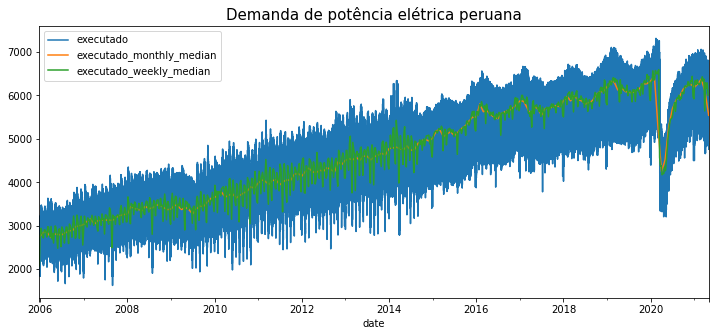

In [13]:
# todo o período

# aplica média
monthly_median = df_hist.resample('M').median().add_suffix('_monthly_median')
weekly_median = df_hist.resample('W').median().add_suffix('_weekly_median')

# plota no mesmo eixo
axes = df_hist.plot(figsize=(12,5))
monthly_median.plot(ax=axes)
weekly_median.plot(ax=axes)

plt.title('Demanda de potência elétrica peruana', fontsize=15)
plt.show()

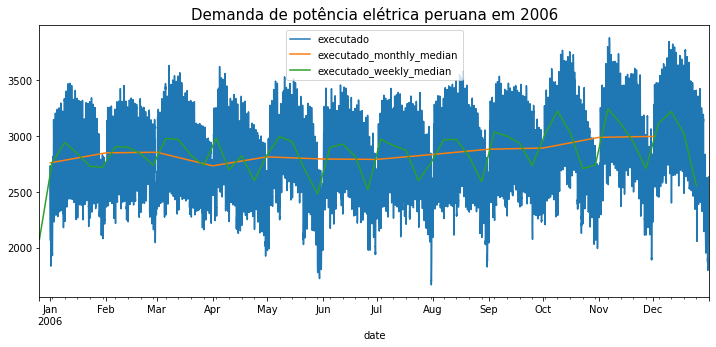

In [14]:
# apenas dados de 2006
df_2006 = df_hist['2006']

# aplica média
monthly_median = df_2006.resample('M').median().add_suffix('_monthly_median')
weekly_median = df_2006.resample('W').median().add_suffix('_weekly_median')

# plota no mesmo eixo
axes = df_2006.plot(figsize=(12,5))
monthly_median.plot(ax=axes)
weekly_median.plot(ax=axes)

plt.title('Demanda de potência elétrica peruana em 2006', fontsize=15)
plt.show()

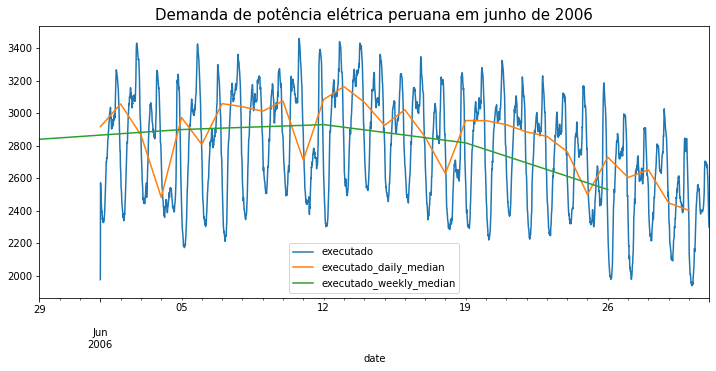

In [15]:
# apenas dados de junho de 2006
df_2006_06 = df_hist['2006-06']

# aplica média
daily_median = df_2006_06.resample('D').median().add_suffix('_daily_median')
weekly_median = df_2006_06.resample('W').median().add_suffix('_weekly_median')

# plota no mesmo eixo
axes = df_2006_06.plot(figsize=(12,5))
daily_median.plot(ax=axes)
weekly_median.plot(ax=axes)

plt.title('Demanda de potência elétrica peruana em junho de 2006', fontsize=15)
plt.show()

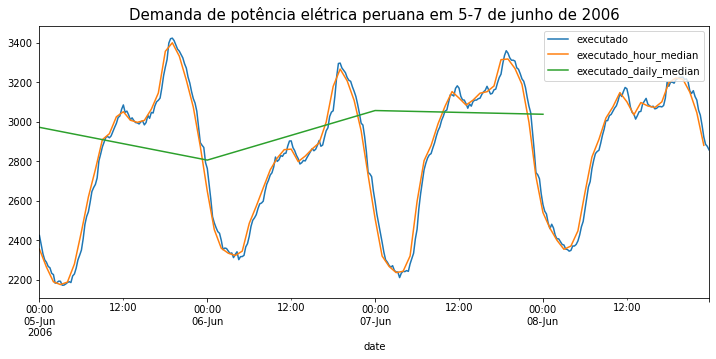

In [16]:
# apenas dados de junho de 2006
df_2006_06_d = df_hist['2006-06-05':'2006-06-08']

# aplica média e mediana
hour_median = df_2006_06_d.resample('H').median().add_suffix('_hour_median')
daily_median = df_2006_06_d.resample('D').median().add_suffix('_daily_median')

# plota no mesmo eixo
axes = df_2006_06_d.plot(figsize=(12,5))
hour_median.plot(ax=axes)
daily_median.plot(ax=axes)

plt.title('Demanda de potência elétrica peruana em 5-7 de junho de 2006', fontsize=15)
plt.show()

In [17]:
print(df_hist.asfreq('15T'))
df_hist.asfreq('15T').isnull().sum()

                      executado
date                           
2006-01-01 00:00:00  2069.01876
2006-01-01 00:15:00  2733.44840
2006-01-01 00:30:00  2681.27092
2006-01-01 00:45:00  2633.54249
2006-01-01 01:00:00  2611.28745
...                         ...
2021-05-02 22:45:00  5842.71088
2021-05-02 23:00:00  5789.96126
2021-05-02 23:15:00  5708.78075
2021-05-02 23:30:00  5660.78965
2021-05-02 23:45:00  5583.32887

[537696 rows x 1 columns]


executado    0
dtype: int64

## 1.2 - Tempo

**Dados meteorológicos**: histórico de temperatura e umidade da cidade mais
populosa do Peru (Lima), com intervalo de amostragem de 1 hora. A seguir um
descritivo breve das colunas presentes na base de dados.
<ul>
  <li>a. Nome do arquivo: Temperatura Lima 2018 - 2021.csv</li>
  <li>b. Colunas</li>
    <ul>
      <li>i. FECHA: momento da amostragem dos dados meteorológicos</li>
      <li>ii. TEMPERATURA (°C): temperatura medida, em graus Celsius (°C)</li>
      <li>iii. PRECIPITACIÓN (mm/hora): precipitação medida, em milímetro por hora (mm/hora)</li>
      <li> iv. HUMEDAD (%): umidade medida, em porcentagem (%)</li>
      <li> v. DIRECCION DEL VIENTO (°): direção do vento, em graus (o)</li>
      <li>vi. VELOCIDAD DEL VIENTO (m/s): velocidade do vento, m/s</li>

O primeiro problema problema que foi encontrado foi na instância 61564 que apresenta um erro em seus valores que será tratado de forma a apenas colocar seus valores de 'DATE' e 'HOUR', anulando o restante.

In [18]:
list_61564 = df_tempo.iloc[61564,:]['DATE'].split(',')
df_tempo.loc[61564,'DATE'] = list_61564[0]
df_tempo.loc[61564,'HOUR'] = list_61564[1]

Ao começar a lidar com o dataset de Tempo, percebeu-se alguns erros tratados a seguir, primeiramente, percebe-se que há instâncias não apresentam valor na coluna hora e que esse valor está junto à coluna date, a seguir isso é corrigido para que por todo o dataset tenhamos as colunas de hora e data separadamente.

In [19]:
df_tempo['DATE'] = pd.to_datetime(df_tempo['DATE'], errors='raise')
df_tempo['HOUR'] = pd.to_datetime(df_tempo['HOUR'], errors='raise')

In [20]:
df_tempo

,DATE,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL
0,2006-01-01,NaT,NaN,NaN,NaN,NaN,NaN
1,2006-01-02,NaT,NaN,NaN,NaN,NaN,NaN
2,2006-01-03,NaT,NaN,NaN,NaN,NaN,NaN
3,2006-01-04,NaT,NaN,NaN,NaN,NaN,NaN
4,2006-01-05,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
116929,2021-06-30,2021-06-25 19:00:00,NaN,NaN,NaN,NaN,NaN
116930,2021-06-30,2021-06-25 20:00:00,NaN,NaN,NaN,NaN,NaN
116931,2021-06-30,2021-06-25 21:00:00,NaN,NaN,NaN,NaN,NaN
116932,2021-06-30,2021-06-25 22:00:00,NaN,NaN,NaN,NaN,NaN


In [21]:
df_tempo['HOUR'] = df_tempo['HOUR'].dt.time

In [22]:
subst = df_tempo[df_tempo['HOUR'].isnull() == True]['DATE'].dt.time
lista_nulos = list(df_tempo[df_tempo['HOUR'].isnull() == True]['HOUR'].index)
df_tempo.loc[lista_nulos, 'HOUR'] = subst

In [23]:
df_tempo

,DATE,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL
0,2006-01-01,00:00:00,NaN,NaN,NaN,NaN,NaN
1,2006-01-02,00:00:00,NaN,NaN,NaN,NaN,NaN
2,2006-01-03,00:00:00,NaN,NaN,NaN,NaN,NaN
3,2006-01-04,00:00:00,NaN,NaN,NaN,NaN,NaN
4,2006-01-05,00:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
116929,2021-06-30,19:00:00,NaN,NaN,NaN,NaN,NaN
116930,2021-06-30,20:00:00,NaN,NaN,NaN,NaN,NaN
116931,2021-06-30,21:00:00,NaN,NaN,NaN,NaN,NaN
116932,2021-06-30,22:00:00,NaN,NaN,NaN,NaN,NaN


Uma primeira observação é que, com exceção das colunas de data e hora, o restante das colunas apresentam um número significativo de valores nulos.

A coluna 'HOUR' foi convertida para um tipo 'datetime.time' que aparece aqui como um 'dtype' de 'object'.

As colunas 'DATE' e 'HOUR' serão utilizadas como index

In [24]:
#index = pd.MultiIndex.from_frame(df_tempo[['DATE','HOUR']])
index = df_tempo['DATE'].copy()

# Usando DateTimeIndex
df_tempo.index = index
df_tempo.index.name = 'DATE'
df_tempo = df_tempo.drop(['DATE'], axis=1)

In [25]:
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116934 entries, 2006-01-01 to 2021-06-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   HOUR    116934 non-null  object 
 1   TEMP    98744 non-null   float64
 2   PREC_H  72417 non-null   float64
 3   HUM     98773 non-null   float64
 4   W_DIR   98758 non-null   float64
 5   W_VEL   98760 non-null   float64
dtypes: float64(5), object(1)
memory usage: 6.2+ MB


In [26]:
df_tempo.iloc[1610:1620,:]

,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL
DATE,,,,,,
2006-12-25,10:00:00,22.3,0.0,76.0,242.0,1.2
2006-12-25,11:00:00,23.0,0.0,72.0,242.0,1.5
2006-12-25,12:00:00,26.2,0.0,61.0,196.0,3.9
2006-12-25,13:00:00,23.3,0.0,69.0,240.0,2.1
2006-12-25,14:00:00,23.4,0.0,69.0,238.0,2.2
2006-12-25,15:00:00,23.0,0.0,73.0,237.0,2.6
2006-12-25,16:00:00,22.8,0.0,73.0,238.0,2.5
2006-12-25,17:00:00,22.5,0.0,73.0,240.0,2.2
2006-12-25,18:00:00,22.0,0.0,76.0,243.0,2.1


Existem dias que apenas temos uma medição à meia noite e outros em que a medição ocorre de hora em hora.

### 1.2.1 Analisando períodos

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2babadf910>,
      dtype=object)

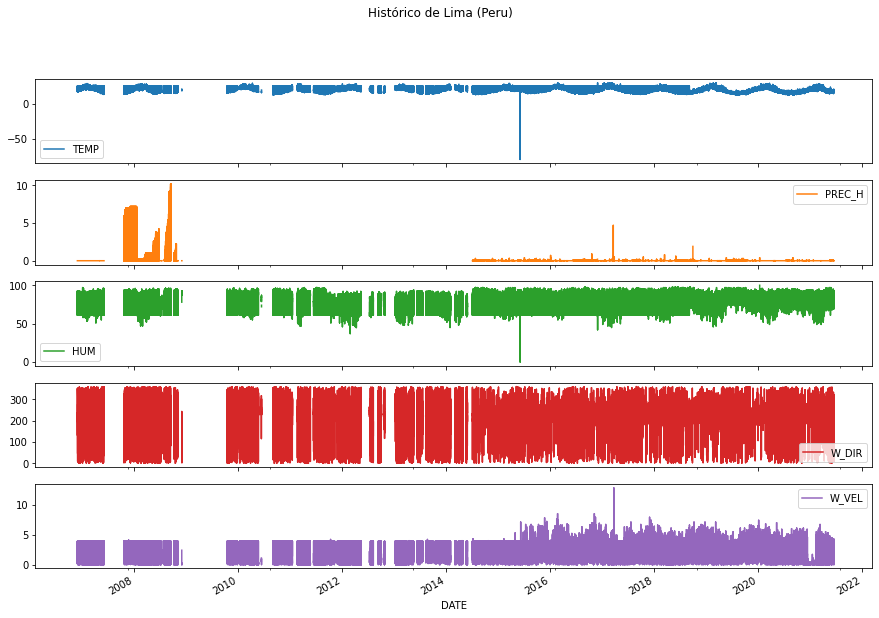

In [27]:
df_tempo.plot(
    title="Histórico de Lima (Peru)", 
    subplots=True, 
    figsize=(15,10))


#2 - Feature engineering

In [28]:
### Perguntas Direcionadoras ###
#Quais são as features que podem ajudar a prever a demanda elétrica?
#Lembrem-se de correlação vs causalidade

## 2.1. Preparando os Datasets


Lidando com os valores NaN de df_tempo, vamos usar apenas aqueles que tem algum valor nas colunas.

In [29]:
df_tempo.shape

(116934, 6)

In [30]:
df_tempo.isnull().sum()

HOUR          0
TEMP      18190
PREC_H    44517
HUM       18161
W_DIR     18176
W_VEL     18174
dtype: int64

Criando um dataset apenas com valores válidos do df_tempo.

In [31]:
#df_tempo_val = df_tempo.dropna(axis=0, how='all', thresh=None, subset=['TEMP','PREC_H','HUM','W_DIR','W_VEL'], inplace=False)
#df_tempo_val


Repare que ainda temos valores nulos, mas são linhas que contem pelo menos uma informação não nula.

In [32]:
df_tempo.isnull().sum()

HOUR          0
TEMP      18190
PREC_H    44517
HUM       18161
W_DIR     18176
W_VEL     18174
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ba4ab9850>,
      dtype=object)

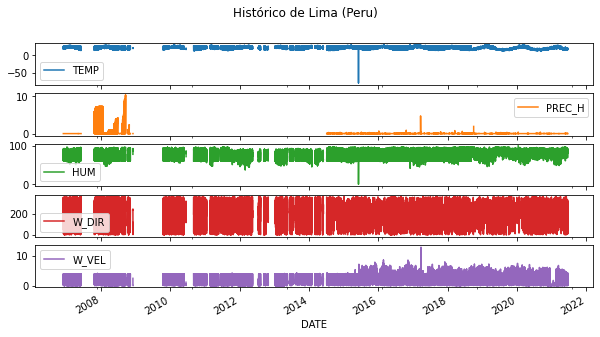

In [33]:
df_tempo.plot(
    title="Histórico de Lima (Peru)", 
    subplots=True, 
    figsize=(10,5))

## 2.2. Juntando os datasets

Para juntar temos que lembrar que o df_tempo tem muitos valores faltantes, sendo que ele só considera o período de 1 hora entre as medições e o df_hist apresenta o histórico à cada 15 min, vamos considerar que os dados de df_tempo valem por toda a hora.

In [34]:
df_tempo['col1'] = df_tempo.index.astype('str')
df_tempo['col2'] = df_tempo['HOUR'].apply(lambda t: t.hour).astype('str')
#df_tempo_val['col2'] = df_tempo_val['HOUR'].dt.hour
df_tempo.head(3)

,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL,col1,col2
DATE,,,,,,,,
2006-01-01,00:00:00,NaN,NaN,NaN,NaN,NaN,2006-01-01,0
2006-01-02,00:00:00,NaN,NaN,NaN,NaN,NaN,2006-01-02,0
2006-01-03,00:00:00,NaN,NaN,NaN,NaN,NaN,2006-01-03,0


In [35]:
df_hist['col1'] = df_hist.index.date.astype('str')
df_hist['col2'] = df_hist.index.hour.astype('str')
df_hist.head(3)

,executado,col1,col2
date,,,
2006-01-01 00:00:00,2069.01876,2006-01-01,0
2006-01-01 00:15:00,2733.44840,2006-01-01,0
2006-01-01 00:30:00,2681.27092,2006-01-01,0


In [36]:
df = pd.merge(df_hist, df_tempo,how ='left', on=['col1','col2']).sort_index()  #, right_index=True)
df.set_index(df_hist.index, inplace=True)
#df['EXECUTADO'] = df['executado']
df = df.drop(['col1','col2','HOUR'], axis=1)
df

,executado,TEMP,PREC_H,HUM,W_DIR,W_VEL
date,,,,,,
2006-01-01 00:00:00,2069.01876,NaN,NaN,NaN,NaN,NaN
2006-01-01 00:15:00,2733.44840,NaN,NaN,NaN,NaN,NaN
2006-01-01 00:30:00,2681.27092,NaN,NaN,NaN,NaN,NaN
2006-01-01 00:45:00,2633.54249,NaN,NaN,NaN,NaN,NaN
2006-01-01 01:00:00,2611.28745,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-05-02 22:45:00,5842.71088,18.2,0.0,87.0,209.0,1.3
2021-05-02 23:00:00,5789.96126,18.1,0.0,88.0,210.0,1.7
2021-05-02 23:15:00,5708.78075,18.1,0.0,88.0,210.0,1.7


In [37]:
df.isnull().sum()

executado         0
TEMP         147264
PREC_H       252572
HUM          147148
W_DIR        147208
W_VEL        147200
dtype: int64

## 2.3 - Lidando com valores faltantes

Vamos interpolar para preencher os valores faltantes.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ba42d8e90>,
      dtype=object)

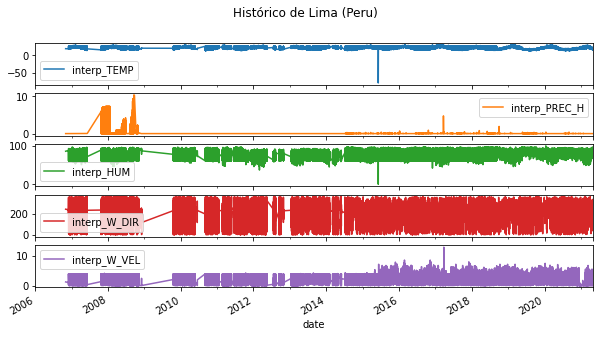

In [38]:
colunas = ['TEMP','PREC_H','HUM','W_DIR','W_VEL']
novas_col = []
for col in colunas:
  nome_col = f'interp_{col}'
  novas_col.append(nome_col)
  df[nome_col] = df[col].interpolate(method='linear')

# Vendo o novo dataset
df[novas_col].plot(
    title="Histórico de Lima (Peru)", 
    subplots=True, 
    figsize=(10,5))

In [39]:
df.drop(colunas, axis=1, inplace=True)

In [40]:
df.isnull().sum()

executado            0
interp_TEMP      29340
interp_PREC_H    29340
interp_HUM       29340
interp_W_DIR     29340
interp_W_VEL     29340
dtype: int64

In [41]:
df2 = df.dropna(axis=0, how='all', subset=novas_col, inplace=False)
print(df2.isnull().sum())
df2

executado        0
interp_TEMP      0
interp_PREC_H    0
interp_HUM       0
interp_W_DIR     0
interp_W_VEL     0
dtype: int64


,executado,interp_TEMP,interp_PREC_H,interp_HUM,interp_W_DIR,interp_W_VEL
date,,,,,,
2006-11-02 15:00:00,3130.21038,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 15:15:00,3129.52409,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 15:30:00,3135.43278,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 15:45:00,3144.80706,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 16:00:00,3167.88792,19.099853,0.0,86.000734,240.998165,1.199927
...,...,...,...,...,...,...
2021-05-02 22:45:00,5842.71088,18.200000,0.0,87.000000,209.000000,1.300000
2021-05-02 23:00:00,5789.96126,18.100000,0.0,88.000000,210.000000,1.700000
2021-05-02 23:15:00,5708.78075,18.100000,0.0,88.000000,210.000000,1.700000


In [42]:
#df2.plot(title="Demanda de Potência Elétrica em Lima (Peru)",     subplots=True,    figsize=(15,10))

O período analisado é de 02/11/2006 à 02/05/2021

In [43]:
print(min(df2.index))
print(max(df2.index))

2006-11-02 15:00:00
2021-05-02 23:45:00


In [44]:
df2.describe(include='all')


,executado,interp_TEMP,interp_PREC_H,interp_HUM,interp_W_DIR,interp_W_VEL
count,508356.000000,508356.000000,508356.000000,508356.000000,508356.000000,508356.000000
mean,4641.885161,19.890811,0.298403,81.100512,217.389074,1.607937
std,1131.037424,3.201383,1.265047,8.708326,44.627400,1.188877
min,1624.031180,-80.000000,0.000000,0.000000,0.000000,0.000000
25%,3694.852612,17.250340,0.000000,76.000000,209.000000,0.700000
50%,4649.556800,19.800000,0.000000,83.000000,222.000000,1.400000
75%,5550.116835,22.024176,0.000000,87.724594,233.000000,2.300000
max,7316.133020,31.000000,10.200000,100.000000,360.000000,12.800000


In [45]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508356 entries, 2006-11-02 15:00:00 to 2021-05-02 23:45:00
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   executado      508356 non-null  float64
 1   interp_TEMP    508356 non-null  float64
 2   interp_PREC_H  508356 non-null  float64
 3   interp_HUM     508356 non-null  float64
 4   interp_W_DIR   508356 non-null  float64
 5   interp_W_VEL   508356 non-null  float64
dtypes: float64(6)
memory usage: 27.1 MB


In [46]:
df2.isnull().sum()

executado        0
interp_TEMP      0
interp_PREC_H    0
interp_HUM       0
interp_W_DIR     0
interp_W_VEL     0
dtype: int64

In [47]:
print(df2.asfreq('15T'))
df_freq = df2.asfreq('15T', method='ffill')
df_freq

                      executado  interp_TEMP  ...  interp_W_DIR  interp_W_VEL
date                                          ...                            
2006-11-02 15:00:00  3130.21038    19.100000  ...    241.000000      1.200000
2006-11-02 15:15:00  3129.52409    19.100000  ...    241.000000      1.200000
2006-11-02 15:30:00  3135.43278    19.100000  ...    241.000000      1.200000
2006-11-02 15:45:00  3144.80706    19.100000  ...    241.000000      1.200000
2006-11-02 16:00:00  3167.88792    19.099853  ...    240.998165      1.199927
...                         ...          ...  ...           ...           ...
2021-05-02 22:45:00  5842.71088    18.200000  ...    209.000000      1.300000
2021-05-02 23:00:00  5789.96126    18.100000  ...    210.000000      1.700000
2021-05-02 23:15:00  5708.78075    18.100000  ...    210.000000      1.700000
2021-05-02 23:30:00  5660.78965    18.100000  ...    210.000000      1.700000
2021-05-02 23:45:00  5583.32887    18.100000  ...    210.000000 

,executado,interp_TEMP,interp_PREC_H,interp_HUM,interp_W_DIR,interp_W_VEL
date,,,,,,
2006-11-02 15:00:00,3130.21038,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 15:15:00,3129.52409,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 15:30:00,3135.43278,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 15:45:00,3144.80706,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 16:00:00,3167.88792,19.099853,0.0,86.000734,240.998165,1.199927
...,...,...,...,...,...,...
2021-05-02 22:45:00,5842.71088,18.200000,0.0,87.000000,209.000000,1.300000
2021-05-02 23:00:00,5789.96126,18.100000,0.0,88.000000,210.000000,1.700000
2021-05-02 23:15:00,5708.78075,18.100000,0.0,88.000000,210.000000,1.700000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ba56a3d50>,
      dtype=object)

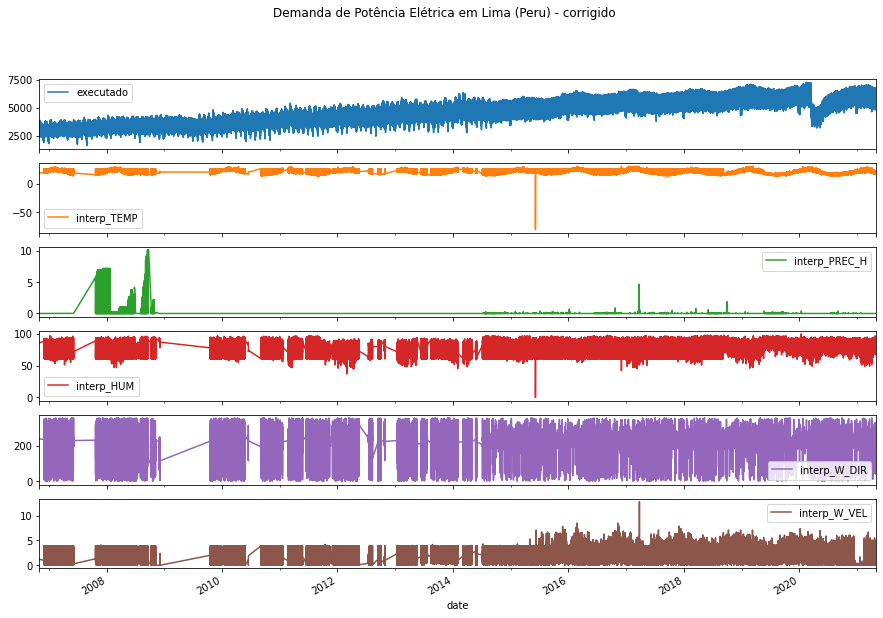

In [48]:
df_freq.plot(
    title="Demanda de Potência Elétrica em Lima (Peru) - corrigido", 
    subplots=True, 
    figsize=(15,10))

#3 - Construção do Modelo

In [49]:
#Dica 1: pense nas métricas de sucesso
#Dica 2: pense numa janela para o test set coerente com o problema (sugestão: utilize pelo menos 1 mês)
#Dica 3: comece com modelos mais simples
#ATENÇÃO!: cuidado com vazamento de dados do train set para o test set!

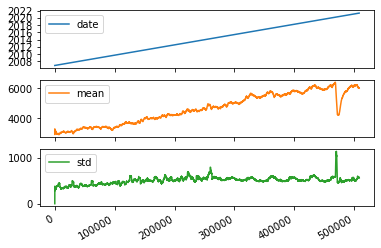

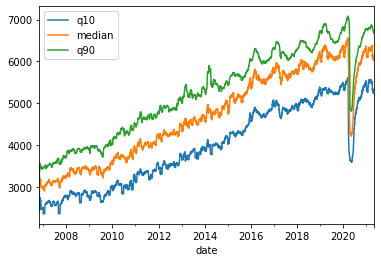

In [50]:
#Criando a função de janela rolante
# Método 1
r = df2.executado.rolling('30D').agg(['mean', 'std']).reset_index()    # calculo de média e desvio padrao
r.plot(subplots = True)                                 # plot separadamente

# Método 2
rolling = df2.executado.rolling('30D')                  # armazena janela em variavel
q10 = rolling.quantile(.1).to_frame('q10')              # calculo do 10 quartil (q10)
median = rolling.median().to_frame('median')            # cálculo da mediana
q90 = rolling.quantile(.9).to_frame('q90')              # calculo do 90 quartil (q90)
pd.concat([q10, median, q90], axis=1).plot()

In [51]:
df2.loc[:,'LAGGED'] = df2.loc[:,'executado'].shift(periods=-1)
df2.loc[:,'DIFF'] = df2.loc[:,'LAGGED'].diff()
df2.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,executado,interp_TEMP,interp_PREC_H,interp_HUM,interp_W_DIR,interp_W_VEL,LAGGED,DIFF
date,,,,,,,,
2006-11-02 15:00:00,3130.21038,19.100000,0.0,86.000000,241.000000,1.200000,3129.52409,NaN
2006-11-02 15:15:00,3129.52409,19.100000,0.0,86.000000,241.000000,1.200000,3135.43278,5.90869
2006-11-02 15:30:00,3135.43278,19.100000,0.0,86.000000,241.000000,1.200000,3144.80706,9.37428
2006-11-02 15:45:00,3144.80706,19.100000,0.0,86.000000,241.000000,1.200000,3167.88792,23.08086
2006-11-02 16:00:00,3167.88792,19.099853,0.0,86.000734,240.998165,1.199927,3171.38806,3.50014


## 3.1 - Divisão treino/teste

In [52]:
df_freq.loc[:,'LAGGED'] = df2.loc[:,'executado'].shift(periods=-1)
df_freq.loc[:,'DIFF'] = df2.loc[:,'LAGGED'].diff()

In [53]:
X = df_freq['executado']
y = df_freq.drop(['executado','LAGGED'], axis=1)

print("X:", X.shape)
print(X.head())
print("y:", y.shape)
print(y.head())

X: (508356,)
date
2006-11-02 15:00:00    3130.21038
2006-11-02 15:15:00    3129.52409
2006-11-02 15:30:00    3135.43278
2006-11-02 15:45:00    3144.80706
2006-11-02 16:00:00    3167.88792
Freq: 15T, Name: executado, dtype: float64
y: (508356, 6)
                     interp_TEMP  interp_PREC_H  ...  interp_W_VEL      DIFF
date                                             ...                        
2006-11-02 15:00:00    19.100000            0.0  ...      1.200000       NaN
2006-11-02 15:15:00    19.100000            0.0  ...      1.200000   5.90869
2006-11-02 15:30:00    19.100000            0.0  ...      1.200000   9.37428
2006-11-02 15:45:00    19.100000            0.0  ...      1.200000  23.08086
2006-11-02 16:00:00    19.099853            0.0  ...      1.199927   3.50014

[5 rows x 6 columns]


## 3.2 - Validação Cruzada

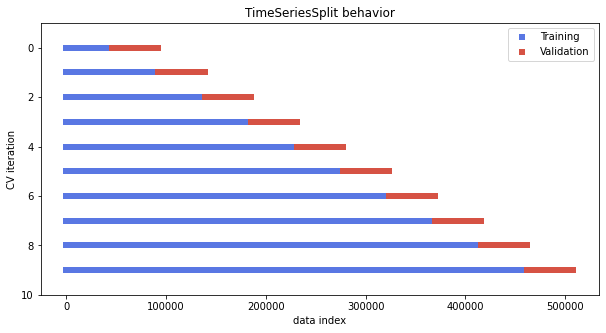

In [54]:
# using fixed history to train
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=10)

# now plotting our datasets for cross-validation
fig, ax = plt.subplots(figsize=(10, 5))
for index, (X_train, X_test) in enumerate(cv.split(X)):
    # Plot training and test indices
    l1 = ax.scatter(X_train, [index] * len(X_train), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(X_test, [index] * len(X_test), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

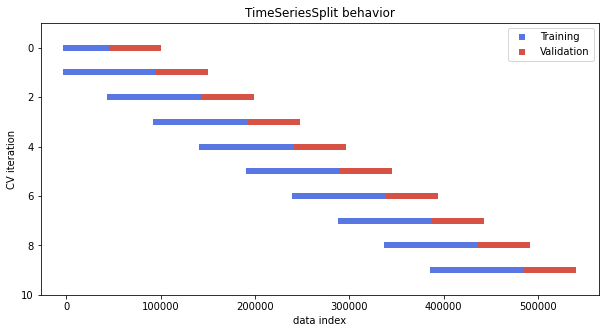

In [55]:
# janela rolante
# utiliza histórico fixo para treino
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=10, max_train_size=100000)

fig, ax = plt.subplots(figsize=(10, 5))
for index, (train, test) in enumerate(cv.split(df)):
    # Plota índices de treino e teste
    l1 = ax.scatter(train, [index] * len(train), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(test, [index] * len(test), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

## 3.3 - Decomposição

In [56]:
df_freq.rename({'executado':'y'}, axis=1, inplace=True)

In [57]:
# vamos fazer o split entre série de treino e teste
train_ts = df_freq['2018-01':'2020-12']['y']
test_ts = df_freq['2021-01':]['y']

# tamanho da divisão:
print("Tamanho do conjunto de treino: ", train_ts.shape)
print("Tamanho do conjunto de teste:  ", test_ts.shape)
# visualização do set de treino
train_ts.head()

Tamanho do conjunto de treino:  (105216,)
Tamanho do conjunto de teste:   (11712,)


date
2018-01-01 00:00:00    5253.16096
2018-01-01 00:15:00    5101.84315
2018-01-01 00:30:00    5042.23476
2018-01-01 00:45:00    5033.61621
2018-01-01 01:00:00    4979.18002
Freq: 15T, Name: y, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


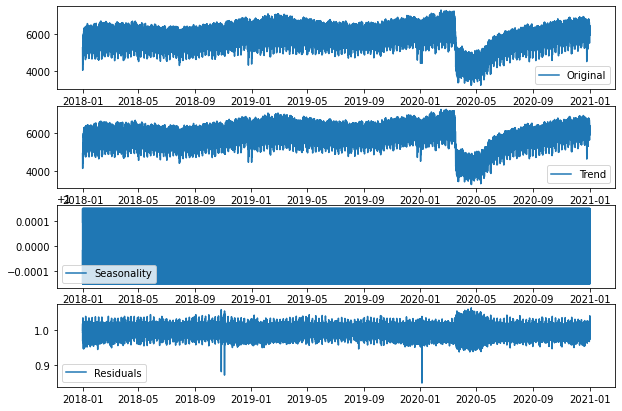

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

# cria modelo
decomposition = seasonal_decompose(train_ts, model='multiplicative', freq=int((24*60)/(15*7))  )
# teste tambem com model='additive' e veja se você nota alguma diferença

# define os componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plots
plt.subplots(figsize=(10, 7))
plt.subplot(411)
plt.plot(train_ts, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

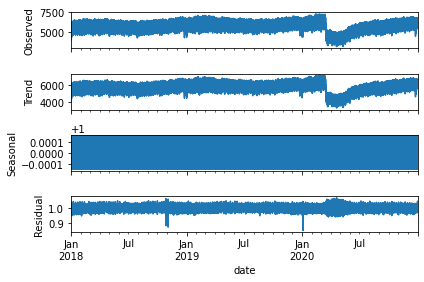

In [59]:
decomposition.plot()
plt.show()

## 3.5 - Modelos

### 3.5.1 - Média móvel

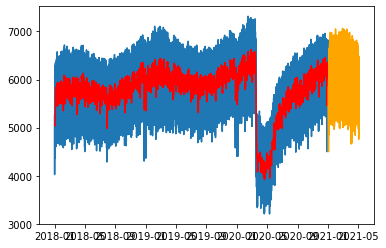

In [60]:
# média móvel dos últimos 200 dias
moving_avg = train_ts.rolling(window=200).mean()
plt.plot(train_ts)
plt.plot(moving_avg, color='red')
plt.plot(test_ts, color='orange')

### 3.5.2 - Amortecimento Exponencial

In [61]:
# importa biblioteca
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# cria classe
expsmoothing = ExponentialSmoothing(train_ts)

# fit do modelo
expsmoothing_fit = expsmoothing.fit()

# previsao
expsmoothing_yhat = expsmoothing_fit.predict(start=test_ts.index[0], end=test_ts.index[-1])

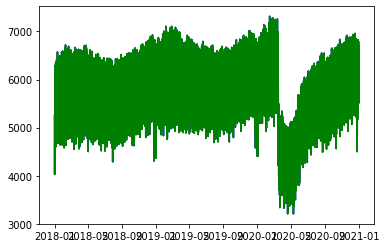

In [62]:
# plot dos resultados nos dados de treino:
plt.plot(train_ts, color='blue')
plt.plot(expsmoothing_fit.predict(start=train_ts.index[0], end=train_ts.index[-1]), color='green')

In [63]:
expsmoothing_yhat

2021-01-01 00:00:00    5953.38752
2021-01-01 00:15:00    5953.38752
2021-01-01 00:30:00    5953.38752
2021-01-01 00:45:00    5953.38752
2021-01-01 01:00:00    5953.38752
                          ...    
2021-05-02 22:45:00    5953.38752
2021-05-02 23:00:00    5953.38752
2021-05-02 23:15:00    5953.38752
2021-05-02 23:30:00    5953.38752
2021-05-02 23:45:00    5953.38752
Freq: 15T, Length: 11712, dtype: float64

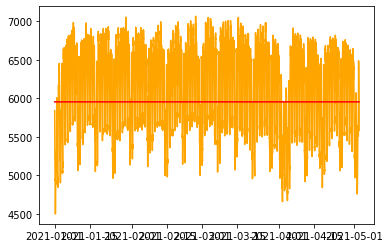

In [64]:
# Plot da previsão nos dados de teste
plt.plot(test_ts, color='orange')
plt.plot(expsmoothing_yhat, color='red')

In [65]:
# dataset para medir erro
exp_forecast = pd.concat([train_ts.append(test_ts),
                          expsmoothing_yhat.rename('yhat')], axis=1, sort=False)

exp_forecast.tail()

,y,yhat
date,,
2021-05-02 22:45:00,5842.71088,5953.38752
2021-05-02 23:00:00,5789.96126,5953.38752
2021-05-02 23:15:00,5708.78075,5953.38752
2021-05-02 23:30:00,5660.78965,5953.38752
2021-05-02 23:45:00,5583.32887,5953.38752


In [66]:
# função reutilizável para cálculo de erros
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [67]:
# métricas de erro
for err_name, err_value in calculate_forecast_errors(exp_forecast, len(test_ts)).items():
    print(err_name, err_value)

MAPE 8.249474710959872
MAE 507.6104547694658


### 3.5.3 - Arima

In [68]:
# importando a biblioteca
from statsmodels.tsa.arima_model import ARIMA

# fit do modelo
ar_model = ARIMA(train_ts, order=(1, 1, 2))  # especificando a ordem do ARIMA: order=(p, d, q)
ar_fit = ar_model.fit(disp=False)

# previsão
ar_yhat = ar_fit.predict(test_ts.index[0], test_ts.index[-1], typ='levels')

KeyboardInterrupt: ignored

In [ ]:
# plot results
plt.plot(test_ts, color='orange')
plt.plot(ar_yhat, color='red')

In [ ]:
# dataset para medir erro
arima_forecast = pd.concat([train_ts.append(test_ts),
                            ar_yhat.rename('yhat')], axis=1, sort=False)

arima_forecast.tail()

In [ ]:
# métricas de erro
for err_name, err_value in calculate_forecast_errors(arima_forecast, len(test_ts)).items():
    print(err_name, err_value)

### 3.5.4 - Prophet

In [ ]:
# ajuste do dataset de treino
train_prophet = train_ts.reset_index()
train_prophet.columns = ['ds', 'y']
train_prophet.head()

In [ ]:
# adjust do dataset de teste
test_prophet = test_ts.reset_index()
test_prophet.columns = ['ds', 'y']
test_prophet.head()

In [ ]:
# imports
from fbprophet import Prophet

In [ ]:
# instancia prophet e treina
m = Prophet()
m.fit(train_prophet)

In [ ]:
# construção do dataset de teste para alimentar o modelo
future = m.make_future_dataframe(periods=len(test_prophet))

# realiza previsão
forecast = m.predict(future)

In [ ]:
# plot dos resultados
m.plot(forecast);

In [ ]:
# plot das componentes da série
m.plot_components(forecast);

In [ ]:
# função para construir dataset com valores históricos e previsão realizada
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [ ]:
# usa função para construir dataset
prophet_forecast = make_comparison_dataframe(train_prophet.append(test_prophet), forecast)

prophet_forecast.tail()

In [ ]:
# cálculo de erros
for err_name, err_value in calculate_forecast_errors(prophet_forecast, len(test_ts)).items():
    print(err_name, err_value)

In [ ]:
# plot dos resultados
plt.plot(train_ts)
plt.plot(test_ts, color='orange')
plt.plot(prophet_forecast['yhat'], color='red')

### 3.5.5 - Random Forest

#4 - Backtest

In [ ]:
#Dica 1: pense numa janela para o test set coerente com o problema (sugestão: utilize pelo menos 1 mês)
#Dica 2: construa uma função para automatizar esse trabalho
#ATENÇÃO!: cuidado com vazamento de dados do train set para o test set!

#5 - Previsão do dia  03/05/2021

In [ ]:
#Lembre-se de salvar a previsão com o nome do arquivo seguindo o padrão 'VAI_previsao_M6_nome_sobrenome.csv'
#e com a estrutura do arquivo seguindo o mesmo padrão do data set 'Histórico Demanda Elétrica Peru 2006 - 2021.csv'